# **Deriving an Integral Fitting Method**

In [1]:
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# increase dpi and use latex rendering
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 160
mpl.rc('text', usetex=True)

## **1. Set the Coefficients and Plot Spalding's Function (Dimensionless Foam)**

In [2]:
E = 5.0
kappa = 0.41
up = np.linspace(0, 30, 100)

yp = up + 1/E*(np.exp(kappa*up) - 1 - kappa*up - (1/2)*(kappa*up)**2 - (1/6)*(kappa*up)**3)

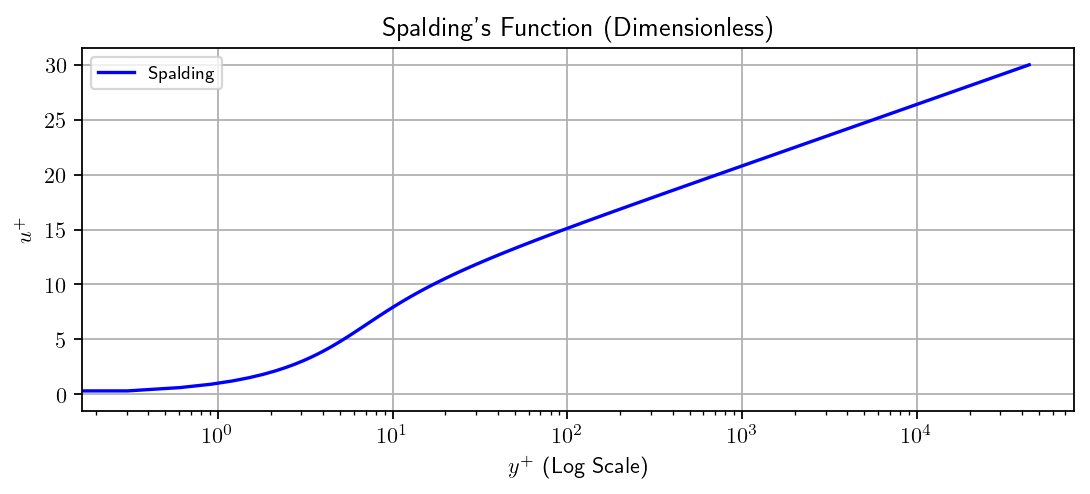

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))    
plt.grid()
ax.set_xlabel(r"$y^+$ (Log Scale)")
ax.set_ylabel(r"$u^+$")
plt.xscale('log')
plt.title(r"Spalding's Function (Dimensionless)")
ax.plot(yp, up, color = "b", label = "Spalding")
ax.legend(fontsize = 8)

## **2. Functions**

1. '*velNewton*' : This function returns the velocity by using **Newton-Raphson's Method (Newton's Method)**.
2. '*velBisection*' : It returns the velocity by using **Bisection Method**.
3. '*y_vel*' : It returns the height of the first cell center normal to the wall '*y*' in order to plot *y-u* relation.

In [4]:
def velNewton(E, kappa, u, u_tau, y, nu):
    error = 1

    while(error > 1e-8):
        f = -(y*u_tau/nu) + u/u_tau + 1/E*(np.exp(kappa*u/u_tau) - 1 - kappa*u/u_tau - (1/2)*(kappa*u/u_tau)**2 - (1/6)*(kappa*u/u_tau)**3)
        df = 1/u_tau + 1/E*(kappa/u_tau*np.exp(kappa*u/u_tau) - kappa/u_tau - (kappa**2/u_tau**2)*u - 1/2*(kappa**3/u_tau**3)*(u**2))
    
        u_new = u - f/df
        error = abs(u_new - u)
        #print(error)
        u = u_new
    # When the process needs to be printed, we can uncomment this.
    #print("Newton : u = {}, u+ = {}, y+ = {}".format(u, u/u_tau, y*u_tau/nu))
    
    return u

def velBisection(E, kappa, u_tau, y, nu, a, b):    
    while((b - a)/2 > 1e-8):
        f_a = -(y*u_tau/nu) + a/u_tau + 1/E*(np.exp(kappa*a/u_tau) - 1 - kappa*a/u_tau - (1/2)*(kappa*a/u_tau)**2 - (1/6)*(kappa*a/u_tau)**3)
        f_b = -(y*u_tau/nu) + b/u_tau + 1/E*(np.exp(kappa*b/u_tau) - 1 - kappa*b/u_tau - (1/2)*(kappa*b/u_tau)**2 - (1/6)*(kappa*b/u_tau)**3)
        #print(f_a)
        c = (a + b)/2
        f_c = -(y*u_tau/nu) + c/u_tau + 1/E*(np.exp(kappa*c/u_tau) - 1 - kappa*c/u_tau - (1/2)*(kappa*c/u_tau)**2 - (1/6)*(kappa*c/u_tau)**3)
        if f_c == 0:
            break
            
        if np.sign(f_c) == np.sign(f_a):
            a = c
        else:
            b = c
    u = c
    # When the process needs to be printed, we can uncomment this.
    #print("Bisection : u = {}, u+ = {}, y+ = {}".format(u, u/u_tau, y*u_tau/nu))
    return u

def y_vel(E, kappa, u, u_tau, nu):
    y = (u/u_tau + 1/E*(np.exp(kappa*u/u_tau) - 1 - kappa*u/u_tau - (1/2)*(kappa*u/u_tau)**2 - (1/6)*(kappa*u/u_tau)**3))/(u_tau/nu)
    
    return y

## **3. Plot Spalding's Function for Various '*u_tau*' with Respect to *u* and *y***

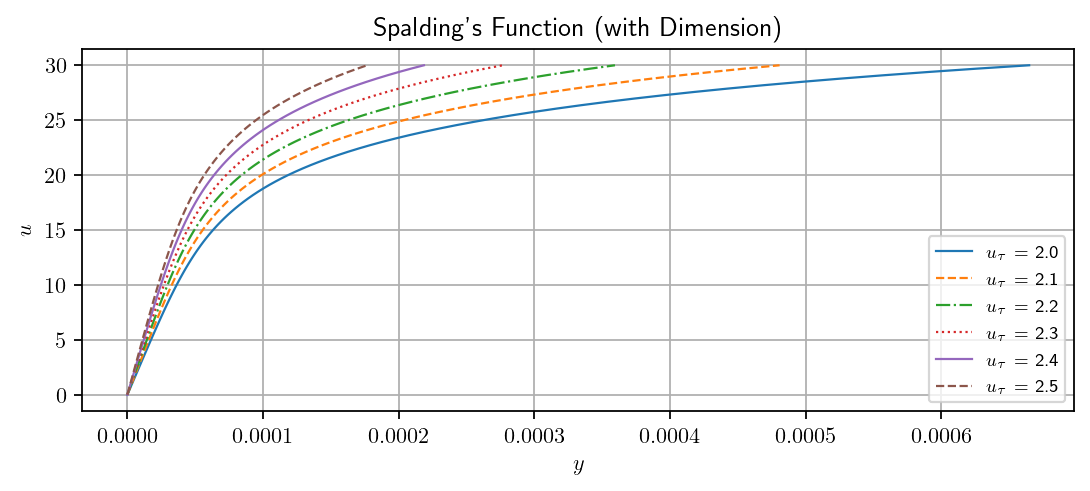

In [5]:
# nu from Turbulent Flat Plate case
nu = 1.388e-05
u_tau_list = [0.1*i+2 for i in range(6)]
u_list = np.linspace(0, 30, 100)

style = ["-", "--", "-.", ":", "-", "--", "-.", ":"]
lw = 1.0
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 3))
plt.grid()
ax2.set_xlabel(r"$y$")
ax2.set_ylabel(r"$u$")
plt.title(r"Spalding's Function (with Dimension)")
for i in range(len(u_tau_list)):
    ax2.plot(y_vel(E, kappa, u_list, u_tau_list[i], nu), u_list, label = r'$u_\tau$ = {}'.format(u_tau_list[i]), ls = style[i], c = "C{:d}".format(i), lw = lw)
    ax2.legend(fontsize = 8)

## **4. Test Newton's Method and Bisection Method**

It is obvious that the results are almost the same between two methods. Regarding the coefficients, '*u_tau*' is found from the value of '*nu*' and '*magGradU*' in *Turbulent Flat Plate* case. '*u*' and '*y*' are set in order to make *y+ = 100*.

In [6]:
u = 20
u_tau = np.sqrt(nu*456605)
y = 0.555e-3

yplus = y*u_tau/nu
uplus = u/u_tau

velNewton(E, kappa, u, u_tau, y, nu)

a = 0
b = 100
velBisection(E, kappa, u_tau, y, nu, a, b)

38.083172764163464

## **5. Calculate New Integral Cell Center and Velocity**

For integration, **Trapezoidal Rule** is used, and each velocity point is calculated by the numerical methods. Consequently, we are able to find the solution of this integral method. The height of the first cell normal to the wall '*yf*' is based on the cell center height of *y+ = 1*. We can observe that both of methods have almost the same solutions.

### 5-1. Newton's Method

In [7]:
# y+ = 1, cellcenter_y = 4.51172e-6
yf = 2*4.51172e-6

num_points = 10
# Sum of trapezoidal parts
trap_sum = 0

for i in range(num_points):
    trap_sum += velNewton(E, kappa, u, u_tau, (yf/num_points)*i, nu) + velNewton(E, kappa, u, u_tau, (yf/num_points)*(i+1), nu)
# u_p_int is the new cell center velocity by integral method.
u_p_int = 1/2*(1/num_points)*trap_sum

print("\nNewton : u_p_int = {}".format(u_p_int))

# y_p_int is the new cell center height by integral method.
y_p_int = y_vel(E, kappa, u_p_int, u_tau, nu)
print("Newton : y_p_int = {}".format(y_p_int))


Newton : u_p_int = 2.0591043499739676
Newton : y_p_int = 4.51021892189912e-06


### 5-2. Bisection Method

An initial interval [a, b] should be long enough. Otherwise, the **Bisection Method** is not able to find the proper solution.

In [8]:
num_points_bi = 10
# Sum of trapezoidal parts
trap_sum_bi = 0

for i in range(num_points_bi):
    trap_sum_bi += velBisection(E, kappa, u_tau, (yf/num_points_bi)*i, nu, a, b) + velBisection(E, kappa, u_tau, (yf/num_points_bi)*(i+1), nu, a, b)
# u_p_int_bi is the new cell center velocity by integral method.
u_p_int_bi = 1/2*(1/num_points_bi)*trap_sum_bi

print("\nBisection : u_p_int_bi = {}".format(u_p_int_bi))

# y_p_int_bi is the new cell center height by integral method.
y_p_int_bi = y_vel(E, kappa, u_p_int_bi, u_tau, nu)
print("Bisection : y_p_int_bi = {}".format(y_p_int_bi))


Bisection : u_p_int_bi = 2.0591043506283313
Bisection : y_p_int_bi = 4.510218923333032e-06


## **6. Plot New Velocity and Cell Center Height for Various '*u_tau*'**

### 6-1. Newton's Method

In [9]:
# y+ = 1, cellcenter_y = 4.51172e-6
yf = 2*4.51172e-6
# New u_tau_list with linear space to plot continuous u_p_int and y_p_int
u_tau_list = np.linspace(1, 20, 100)

num_points = 10
# Sum of trapezoidal parts with vector initialization
trap_sum_list = np.zeros(len(u_tau_list),)
# u and y for integral method with vector initialization
u_p_int_list = np.zeros(len(u_tau_list),)
y_p_int_list = np.zeros(len(u_tau_list),)

for j in range(len(u_tau_list)):
    for i in range(num_points):
        trap_sum_list[j] += velNewton(E, kappa, u, u_tau_list[j], (yf/num_points)*i, nu) + velNewton(E, kappa, u, u_tau_list[j], (yf/num_points)*(i+1), nu)
    # u_p_int is the new cell center velocity by integral method.
    u_p_int_list[j] = 1/2*(1/num_points)*trap_sum_list[j]

# y_p_int is the new cell center height by integral method.
for j in range(len(u_tau_list)):
    y_p_int_list[j] = y_vel(E, kappa, u_p_int_list[j], u_tau_list[j], nu)

### 6-2. Bisection Method

In [10]:
num_points_bi = 10
# Sum of trapezoidal parts with vector initialization
trap_sum_list_bi = np.zeros(len(u_tau_list),)
# u and y for integral method with vector initialization
u_p_int_list_bi = np.zeros(len(u_tau_list),)
y_p_int_list_bi = np.zeros(len(u_tau_list),)

a = 0
b = 1000

for j in range(len(u_tau_list)):
    for i in range(num_points_bi):
        trap_sum_list_bi[j] += velBisection(E, kappa, u_tau_list[j], (yf/num_points_bi)*i, nu, a, b) + velBisection(E, kappa, u_tau_list[j], (yf/num_points_bi)*(i+1), nu, a, b)
    # u_p_int is the new cell center velocity by integral method.
    u_p_int_list_bi[j] = 1/2*(1/num_points_bi)*trap_sum_list_bi[j]

# y_p_int is the new cell center height by integral method.
for j in range(len(u_tau_list)):
    y_p_int_list_bi[j] = y_vel(E, kappa, u_p_int_list_bi[j], u_tau_list[j], nu)

### 6-3. Plot

As seen below, there is no visible discrepancy of behavior between **Newton's Method** and **Bisection Method** if an initial interval [a, b] is long enough. Moreover, it can be observed that the new velocity increases as '*u_tau*' increases, whereas the opposite happens for the new cell center height.

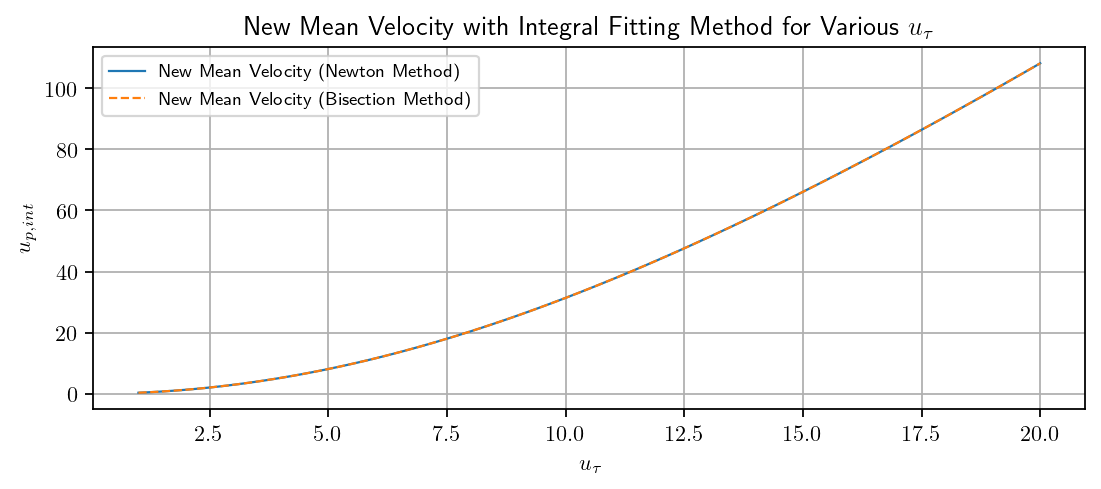

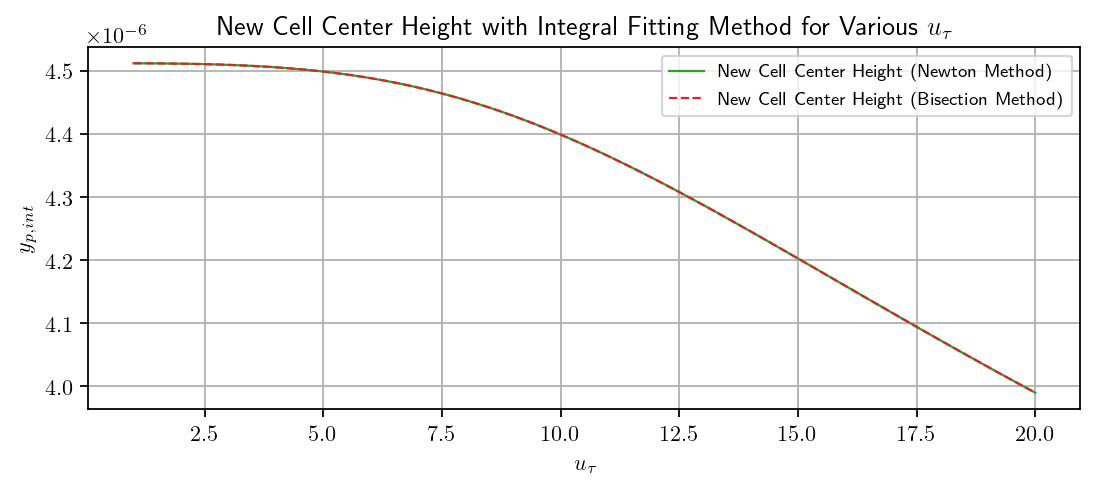

In [11]:
style2 = ["-", "--"]
lw2 = 1.0
# New mean velocity plot
fig3, ax3 = plt.subplots(1, 1, figsize=(8, 3))
plt.grid()
ax3.set_xlabel(r"$u_\tau$")
ax3.set_ylabel(r'$u_{p,int}$')
plt.title(r"New Mean Velocity with Integral Fitting Method for Various $u_\tau$")
ax3.plot(u_tau_list, u_p_int_list, label = r'New Mean Velocity (Newton Method)', ls = style2[0], c = "C{:d}".format(0), lw = lw2)
ax3.plot(u_tau_list, u_p_int_list_bi, label = r'New Mean Velocity (Bisection Method)', ls = style2[1], c = "C{:d}".format(1), lw = lw2)
ax3.legend(fontsize = 8)
# New cell center height plot
fig4, ax4 = plt.subplots(1, 1, figsize=(8, 3))
plt.grid()
ax4.set_xlabel(r"$u_\tau$")
ax4.set_ylabel(r'$y_{p,int}$')
plt.title(r"New Cell Center Height with Integral Fitting Method for Various $u_\tau$")
ax4.plot(u_tau_list, y_p_int_list, label = r'New Cell Center Height (Newton Method)', ls = style2[0], c = "C{:d}".format(2), lw = lw2)
ax4.plot(u_tau_list, y_p_int_list_bi, label = r'New Cell Center Height (Bisection Method)', ls = style2[1], c = "C{:d}".format(3), lw = lw2)
ax4.legend(fontsize = 8)